Remove the eclipsing binary signal using periodic rectangular window

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

# Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plot_helpers import *
plotter = PlotUtilGPyTorch()

Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
    pre { white-space: pre !important; }
</style>
"""))

In [3]:
df = pd.read_csv("./data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

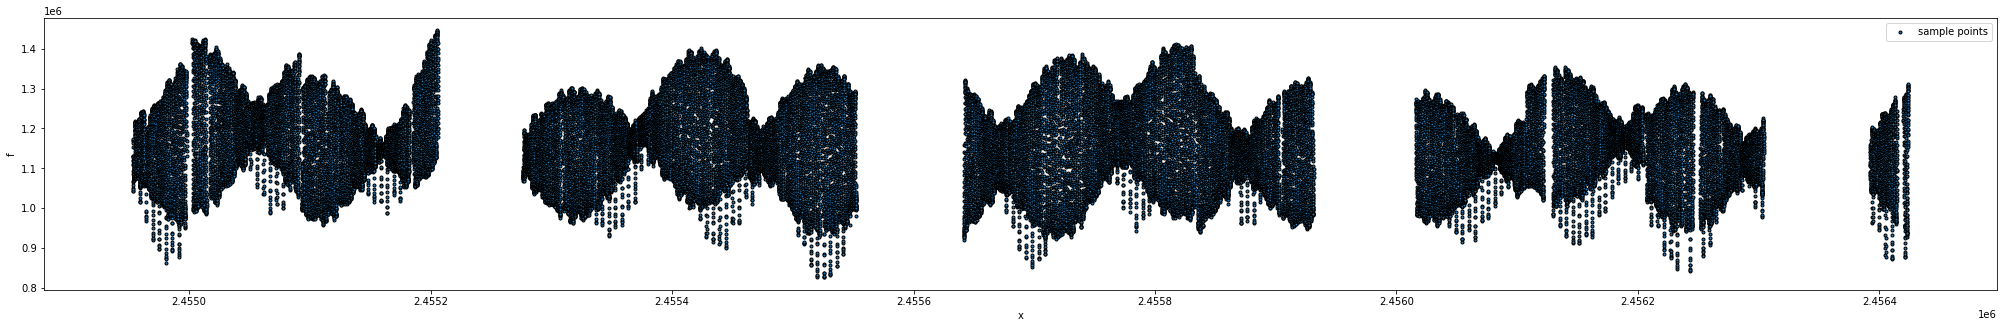

In [5]:
plotter.plot_data(X, Y)

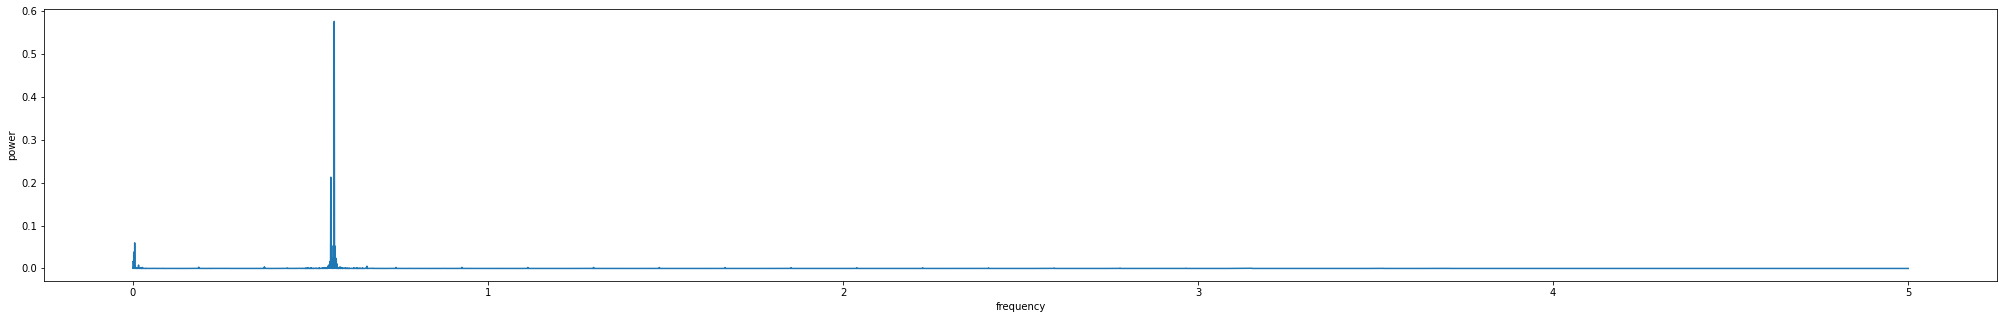

In [6]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)

In [7]:
# First envelope = 12000
N_part=4000 # X.shape[0]

In [8]:
X_part=X[0:N_part]
Y_part=Y[0:N_part]

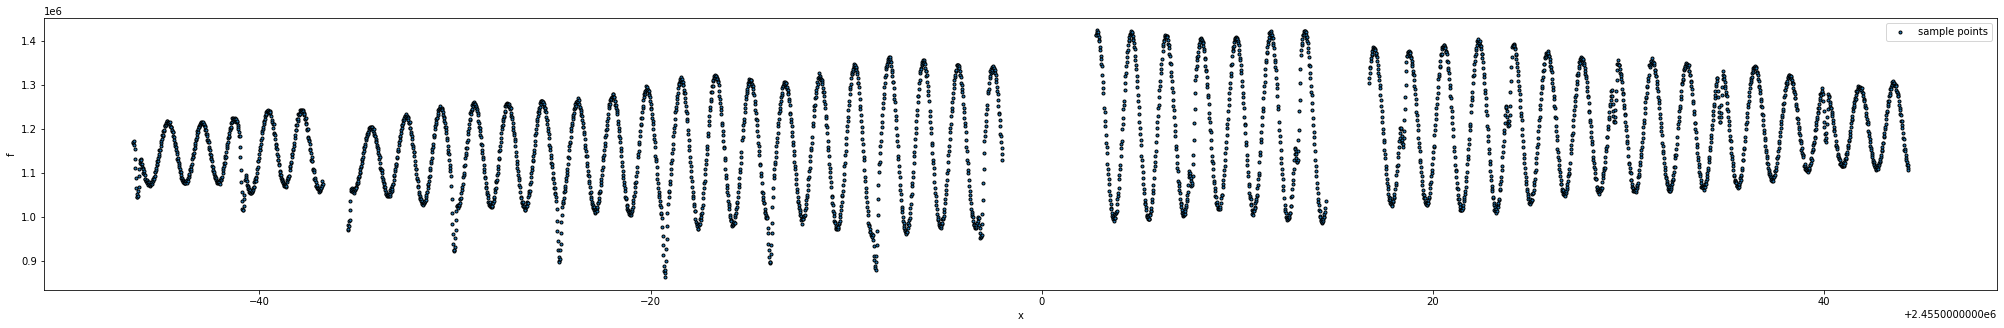

In [9]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [23]:
((np.median(Y_part) - np.mean(Y_part))**2).item()

18932360.170819107

In [10]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.linspace(X_part.min(), X_part.max(), N_part)

In [11]:
def find_nearest_idx(array,value):
    idx = np.searchsorted(array, value, side="left")
#    print(array.shape, value.item(), idx, array[idx].item(), array[idx-1].item())
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def clip_periodic_windows(X, Y, eclipse_duration,
                          eclipse_period, start_prim_eclipse_date, start_sec_eclipse_date):
    """
    Assumptions:
    - the secondary eclipse starts at start_prim_eclipse_date + period_sec_eclipse
    """
    max_date = X.max()

    # Find the next eclipse. Loop over dates here, as the positions in the array will change 
    # when we start deleting windows
    # For the second eclipse, subtract one whole period to make the loop easier to program.
    next_prim_eclipse_date, next_sec_eclipse_date = start_prim_eclipse_date, start_sec_eclipse_date - eclipse_period

    X_clipped = X.copy()
    Y_clipped = Y.copy()

    # Assume the first eclipse is a primary eclipse
    primary_eclipse = True
    next_eclipse_date = next_prim_eclipse_date

    # Now iterate over the data, first the primary eclipse, then a secondary eclipse
    while next_eclipse_date < max_date:
        # There are gaps in the X-data, so we can not delete a window of x pixels, we have to work based on dates.
        next_eclipse_x_start = find_nearest_idx(X_clipped, next_eclipse_date).item()
        next_eclipse_x_end = next_eclipse_x_start + find_nearest_idx(X_clipped[next_eclipse_x_start:], next_eclipse_date+eclipse_duration).item()

        # Now delete the window
        i = { "left" : max(int(next_eclipse_x_start), 0), "right": max(int(next_eclipse_x_end), 0)}
#        print(primary_eclipse, next_eclipse_date.item(), X_clipped[next_eclipse_x_start-2:next_eclipse_x_start+2].tolist(), i)
        X_clipped = np.concatenate((X_clipped[:i['left']], X_clipped[i['right']:]))
        Y_clipped = np.concatenate((Y_clipped[:i['left']], Y_clipped[i['right']:]))

        # Move to the next period
        primary_eclipse = not primary_eclipse
        if primary_eclipse:
            next_prim_eclipse_date += eclipse_period
            next_eclipse_date = next_prim_eclipse_date
        else:
            next_sec_eclipse_date += eclipse_period
            next_eclipse_date = next_sec_eclipse_date
           
    return X_clipped, Y_clipped

In [57]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from functools import partial

def error_mean_vs_median(params, data):
    x, y, sampling_period = data
    eclipse_duration = params['eclipse_duration'] * sampling_period
    eclipse_period = params['eclipse_period'] * sampling_period
    first_prim_eclipse_date = x.min() + params['first_prim_eclipse_date'] * sampling_period
    first_sec_eclipse_date = x.min() + params['first_sec_eclipse_date'] * sampling_period
    
    X_part_window, Y_part_window = clip_periodic_windows(x, y, eclipse_duration,
                                                     eclipse_period, 
                                                     first_prim_eclipse_date, first_sec_eclipse_date
                                                    )
    # We want the smallest amount of deleted samples
    # But also the perfect eclipse removal (median = mean)
    objective = ((np.median(Y_part_window) - np.mean(Y_part_window)) ** 2) +\
                (len(x) - len(X_part_window)) * 2000
    objective = objective.item()
    return {"loss": objective, "status": STATUS_OK}

sampling_period = np.median(np.diff(X_part, n=1)).item()
nr_of_sampling_periods = ((X.max()-X.min()) / sampling_period).item()

# We need to use constrained optimization here.
# eclipse_duration (unit: sampling period), eclipse_period (unit: sampling period), 
# first_prim_eclipse_date (sampling period's since X.min(),
# first_sec_eclipse_date (sampling period's since X.min(),

fmin_objective = partial(error_mean_vs_median, data=(X_part, Y_part, sampling_period))
search_space = {'eclipse_duration': hp.randint('eclipse_duration', 29, 30),
                'eclipse_period': hp.randint('eclipse_period', 3, int(nr_of_sampling_periods/5)),
                'first_prim_eclipse_date': hp.randint('first_prim_eclipse_date', 0, 10),
                'first_sec_eclipse_date': hp.randint('first_sec_eclipse_date', 10, 300)}

trials = Trials()
best_params = fmin(
  fn=fmin_objective,
  space=search_space,
  algo=tpe.suggest,
  max_evals=2000,
  trials=trials)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.02trial/s, best loss: 516333.28115055006]


In [58]:
opt_eclipse_duration = best_params['eclipse_duration'] * sampling_period
opt_eclipse_period = best_params['eclipse_period'] * sampling_period
opt_first_prim_eclipse_date = X_part.min() + best_params['first_prim_eclipse_date'] * sampling_period
opt_first_sec_eclipse_date = X_part.min() + best_params['first_sec_eclipse_date'] * sampling_period

Expected:  0.6130206165835261 10.790492 2454953.6209630514 2454958.9542424157
Optimal:  0.5925865960307419 24.78646693052724 2454953.723133154 2454955.8482712917


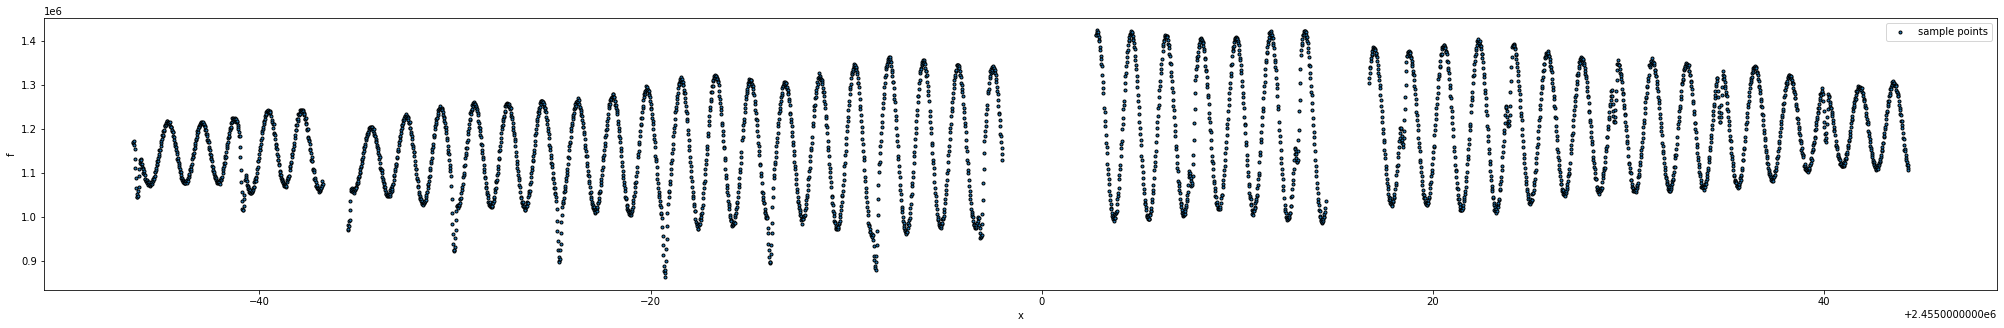

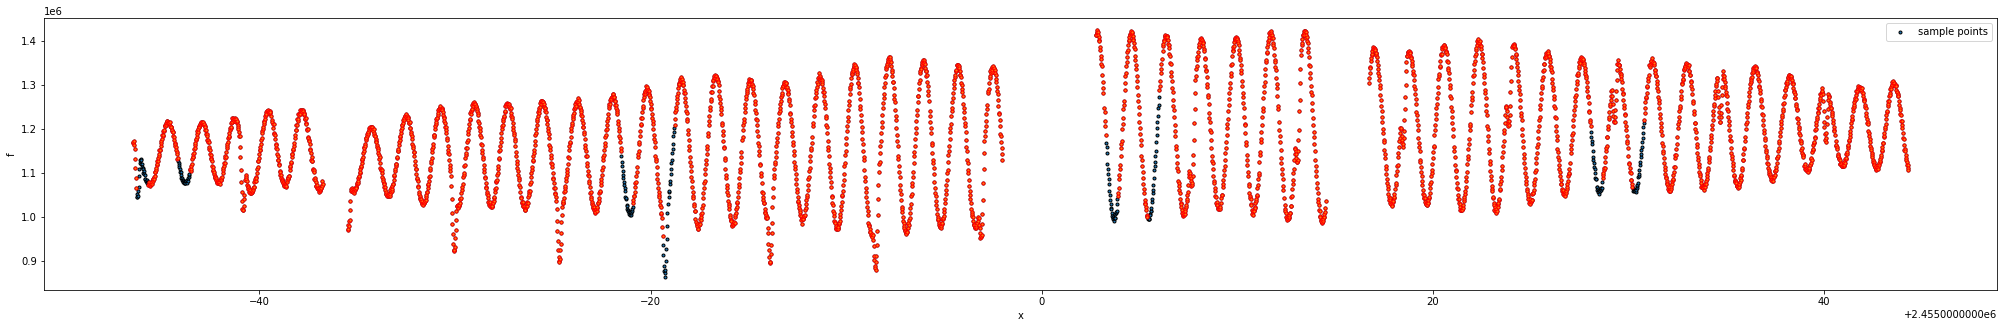

In [59]:
sampling_period = np.median(np.diff(X_part, n=1))
window_size = 30  # todo: window size in duration
exp_eclipse_duration = window_size * sampling_period
exp_first_prim_eclipse_date = X_part[0] + (+4) * sampling_period
exp_first_sec_eclipse_date = X_part[0] + (+265) * sampling_period
exp_eclipse_period=10.790492 # todo: uncertainty

print("Expected: ", exp_eclipse_duration, exp_eclipse_period, exp_first_prim_eclipse_date, exp_first_sec_eclipse_date)
print("Optimal: ", opt_eclipse_duration, opt_eclipse_period, opt_first_prim_eclipse_date, opt_first_sec_eclipse_date)

X_part_window, Y_part_window = clip_periodic_windows(X_part, Y_part, opt_eclipse_duration,
                                                     opt_eclipse_period, 
                                                     opt_first_prim_eclipse_date, opt_first_sec_eclipse_date
                                                    )
plotter.plot_data(X_part, Y_part)
plotter.plot_data(X_part, Y_part, X_part_window, Y_part_window)


In [ ]:
len(X_part_window)

In [19]:
(np.median(Y_part_window) - np.mean(Y_part_window))**2

NameError: name 'Y_part_window' is not defined

In [ ]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part, 0.0, 5)
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)

In [ ]:
def normalize(series):
   mean, std = series.mean(),series.std()
   series = (series - mean) / std
   return mean, std, series

In [ ]:
# !! It's important that we normalize *after* removing the E.B. signal, as that E.B. signal has a major impact on the mean
# In other words, if we normalize first, then remove the E.B., the remaining signal will be somewhere centered around +0.2
# We can not fit any kernel (RBF, Matern...) to a non-normalized signal!!
# normalize labels
mean, std = Y_part_window.mean(),Y_part_window.std()
mean, std, Y_part_window = normalize(Y_part_window)
_, _, Y_part = normalize(Y_part)